<a href="https://colab.research.google.com/github/carlocamilloni/Structural-Bioinformatics/blob/main/Notebooks/t03_MD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Molecular Dynamics simulation with GROMACS

The aim of this experience is to run  Molecular Dynamics simulations of simple systems and analyze them, we will focus on water and alanine dipeptide.

The reference lectures are:

*   https://github.com/carlocamilloni/Structural-Bioinformatics/blob/main/Notes/02_StochasticMolecules.pdf
*   https://github.com/carlocamilloni/Structural-Bioinformatics/blob/main/Notes/03_MolecularDynamics.pdf



## Preliminary setup

Before running this tasl it is helpfull to be sure that we have access to a GPU.

In [ ]:
!nvidia-smi

if the above command is not found, then
`Runtime->change runtime` and select T4-GPU. Once it is ready test the above cell again.

In [ ]:
# install gromacs requirements
!apt update -qq
!apt install -y cmake build-essential libfftw3-dev wget

In [ ]:
# install gromacs
!wget https://ftp.gromacs.org/gromacs/gromacs-2025.3.tar.gz
!tar -xzf gromacs-2025.3.tar.gz
%cd gromacs-2025.3
%mkdir build
%cd build
!cmake .. -DCMAKE_BUILD_TYPE=Release -DGMX_GPU=CUDA
!make -j4
!make install
!ln -s /usr/local/gromacs/bin/gmx /usr/bin/gmx

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive

Make a new folder for this task using the menus on the left side: for example in /drive/MyDrive/Structural_Bioinformatics make a folder named Task3.

In [ ]:
# set the path to your local task folder
local_path='/content/drive/MyDrive/Structural_Bioinformatics/Task3'
%cd {local_path}

In [ ]:
# make a copy of the GitHub structural bioinformatics repository
%cd {local_path}
%cd ..
%rm -rf sb
!git clone https://github.com/carlocamilloni/Structural-Bioinformatics.git sb --depth 1
%cd {local_path}

All GROMACS tools are modules of a binary named `gmx`. To get help about any GROMACS module, you can invoke either of the following commands:
```
gmx help (module)
```
or
```
gmx (module) -h
```
where `(module)` is replaced by the actual name of the command you're trying to issue. A full list of GROMACS modules can be printed by
```
gmx help commands
```
###Units

Basic units in GROMACS are
```
Time: ps
Space: nm
Energy: kJ/mol
```

## Molecular Dynamics of Lysozyme in solution

Here you will setup a simulation for hen egg-white lysozyme, a widely study system in structural biology. Its crystal structure can be find on the PDB as 1AKI

### Initial setup

In [ ]:
# Download the structure from the PDB
%cd {local_path}
!wget https://files.rcsb.org/view/1AKI.pdb

In [ ]:
# Remove structural waters
!grep -v HOH 1AKI.pdb > 1AKI_clean.pdb

At this point one has to select the force field and the water model to be used in the simulation and prepare what is called the topology of the system, that is a file describing all the interactions as they appear in our system of interest. In GROMACS this is done using `pdb2gmx` and selecting some options. Becasue it is not possible to select options in `colab` we will need to provide them as flags:

In [ ]:
# here we use charmm27 as a force field and tip3p as the water model
# we do not set protonation states so that by default we use pH 7
!gmx pdb2gmx -f 1AKI_clean.pdb -o 1AKI_processed.gro -ignh -water tip3p -ff "charmm27"

In [ ]:
# some new files have been created, in particular:
# topol.top is the TOPOLOGY file
# 1AKI_processed.gro is the initial structure in default GROMACS format
%ls

The following step is to place the structure in a BOX that should be large enough to avoid self-interactions of the molecule through the sides but small enough to maximise performances. We set the box using `editconf`.

In [ ]:
# set a dodecahedron like box whose distance from the protein is at least 1.2 nm
!gmx editconf -f 1AKI_processed.gro -bt dodecahedron -d 1.2 -o 1AKI_box.gro

Then we can solvate the protein using `solvate`:

In [ ]:
# here we use spc216.gro coordinates of the solvent that are equivalent to tip3p
!gmx solvate -cp 1AKI_box -cs spc216.gro -p topol.top -o 1AKI_solv.gro

You should see from the log something like 8700 water molecule that have been added to the system.

Next step is to add salts, to do this we need to calculate eletrostatic interactions and so we need to process the topology and structure and generate a GROMACS MD simulation input file. This is done using `grompp` and a molecular dynamics paratemers `.mdp` file. The the resulting file `ions.tpr` is used with the `genion` tool.

In [ ]:
# copy an .mdp file from the downloaded structural bioinformatics repository
%cp ../sb/Data/md/mdps/0-em-steep.mdp .
# prepare a gromacs MD file combining structure, topolgy and parameters
!gmx grompp -f 0-em-steep.mdp -c 1AKI_solv.gro -p topol.top -o ions.tpr -maxwarn 1
# add ions to neutralize the systems at a concentration of 100 mM
# this tool is also interactive and we give in input "12" that means we substitue solvent molecules with salt molecules
!echo -e "13\n" | gmx genion -s ions -conc 0.1 -neutral -p topol.top -o 1AKI_ions

From the log you should see that some Na and Cl atoms have been added to the system.

### Energy minimisation and starting conditions

Before starting an MD simulation the system needs to be in a low energy configuration to avoid too large forces that would made the simulation unstable. This is done preparing a gromacs input file that uses the `steepest descent` algorithm to minimize the energy:

In [ ]:
%cd {local_path}
!gmx grompp -f 0-em-steep.mdp -c 1AKI_ions.gro -p topol.top -o em.tpr

and then running the simulation using `mdrun`:

In [ ]:
!gmx mdrun -deffnm em -v

The simulation takes less than a minute and will stop once some criteria are meet.

In [ ]:
# there are more files now including: em.gro the configuration after the energy minimization
%ls

Now we need to bring the system to the desired temperature and pressure, for this we run our first MD simulation but keeping the protein restraint to its starting configuration, while we let the water reach the correct temperature and density. The protein will also move and reach the correct temperature but avoiding to change its configuration too much.

In [ ]:
%cd {local_path}
%cp ../sb/Data/md/mdps/3-pr-npt.mdp .

You can check the `mdp` file we are gonna use:

```
integrator               = md; we do MD
dt                       = 0.002 ; with a 0.002 ps time step
nsteps                   = 25000 ; for 25000x0.002 = 50 ps (this is too short for real cases)
ref_t                    = 298 ; at 27 C
ref_p                    = 1 ; and 1 bar
```

a more thorough explanation is available here: https://manual.gromacs.org/2025.3/user-guide/mdp-options.html





In [ ]:
%ls
%cat 3-pr-npt.mdp

In [ ]:
%cd {local_path}
!gmx grompp -f 3-pr-npt.mdp -c em.gro -r em.gro -p topol.top -o relax.tpr

In [ ]:
# ready to run it
# CONSIDER THAT IT WILL TAKE 20 MINUTES, be carefull because COLAB can disconnect and stop it
# if you leave your session unattended and the laptop goes to sleep
!gmx mdrun -deffnm relax -v

Now the system is ready to be simulated for production.
In practice we cannot run long MD simulations using the COLAB free plan. The simulation we plan to run is only 200 ps long and still will take more than 1 hour. On a modern workstation with an optimised setup we should get around

In [ ]:
%cd {local_path}
%cp ../sb/Data/md/mdps/5-npt.mdp .

In [ ]:
!gmx grompp -f 5-npt.mdp -c relax.gro -p topol.top -o npt.tpr

In [ ]:
#run it
# CONSIDER THAT IT WILL TAKE MORE THAN 60 MINUTES, be carefull because COLAB can disconnect and stop it
# if you leave your session unattended and the laptop goes to sleep
!gmx mdrun -deffnm npt -v

### Visualisation

Once the simulation is ended you should have few more files:

In [25]:
%ls

 3-pr-npt.mdp             npt_prev.cpt     relax.log       '#relax.trr.2#'
 5-npt.mdp                npt.tpr         '#relax.log.1#'  '#relax.trr.3#'
 condacolab_install.log   npt.trr         '#relax.log.2#'   relax.xtc
 em.gro                   npt.xtc         '#relax.log.3#'  '#relax.xtc.1#'
 ener.edr                 posre.itp        relax_prev.cpt  '#relax.xtc.2#'
 md.log                   relax.cpt        relax.tpr       '#relax.xtc.3#'
 mdout.mdp                relax.edr       '#relax.tpr.1#'   state.cpt
 npt.cpt                 '#relax.edr.1#'  '#relax.tpr.2#'   topol.top
 npt.edr                 '#relax.edr.2#'  '#relax.tpr.3#'   traj_comp.xtc
 npt.gro                 '#relax.edr.3#'   relax.trr        traj.trr
 npt.log                  relax.gro       '#relax.trr.1#'


*   npt.xtc: trajectory file generally including only solute
*   npt.trr: trajectory file including all atoms
*   npt.edr: energy file including all the information about energy
*   npt.gro: last frame of the trajectory
*   npt.cpt: checkpoint file for exact restart

You can look at the trajectory using VMD on your laptop, first load a `1AKI_box.gro` then from the menu FILE choose *Load Data Into Molecule* and select the `npt.xtc` file, this will add all the trajectory frames. You may see something like this:

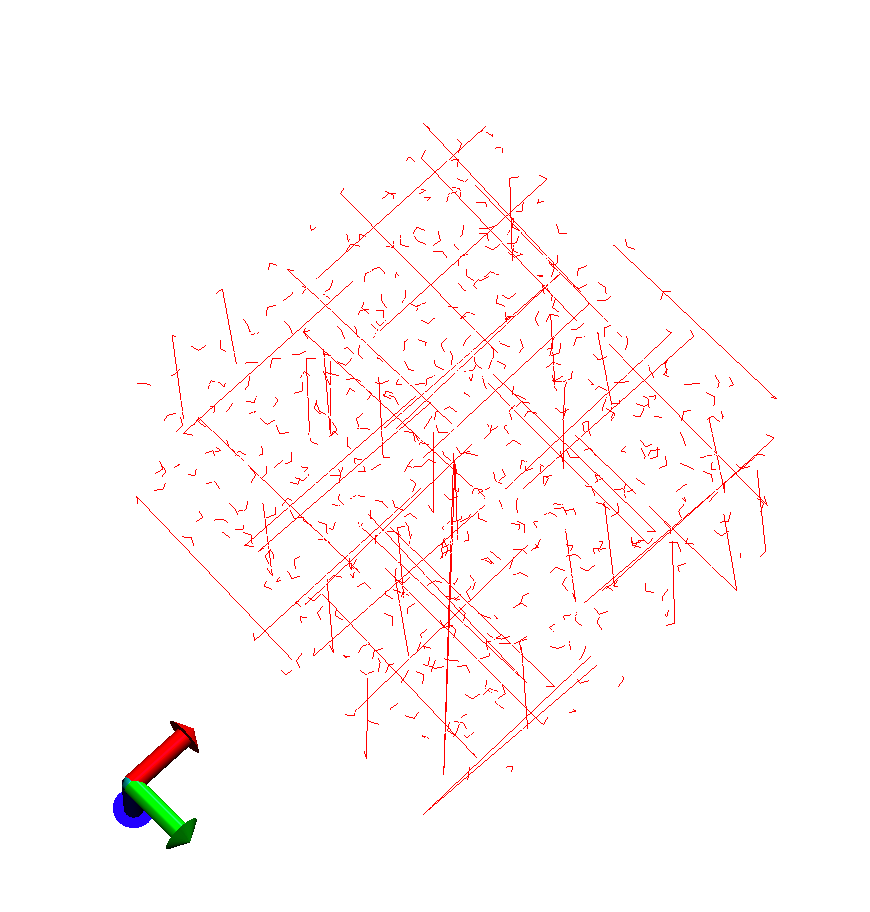

You remember the “PERIODIC BOUNDARY CONDITIONS”? A molecule be cut across the sides of the box. For the purpose of visualisation, we can remove this effect:

In [ ]:
# here trjconv takes in input npt.xtc (-f) and the simulation ready file (-s npt.tpr)
# fix molecules to always be whole through covalent interactions (-pbc mol)
# write a corrected trajctory (-o npt-nopbc.xtc)
!echo -e "1\n" | gmx trjconv -f npt.xtc -s npt.tpr -pbc mol -o npt-nobpc.xtc

Now you have one more file `npt-nopbc.xtc` that is the trajectory with molecules that are not broken across PBC. Close VMD and reopen it loading this new trajectory file. Now we can start to analyse the trajectory

### Analysis

1. Root Mean Square Deviation

2. Root Mean Square Fluctuations

3. Radius of Gyration

4. Secondary structures